# 0.0 IMPORTS


In [2]:
import pandas as pd
import datetime
import numpy as np
import inflection
import seaborn as sns
import math

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate
from scipy import stats as ss


## 0.1 Helper Functions

In [3]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency (cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/min(kcorr-1,rcorr-1))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()


In [4]:
jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data


In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [6]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Rows: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Rows: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].fillna(200000)

#competition_open_since_month    
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

#competition_open_since_year    
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)
                            
#promo2_since_week  
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week)

#promo2_since_year 
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)

#promo_interval     
month_map = {1: 'Jan', 2: 'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype (int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype (int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype (int)

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.nunique())

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

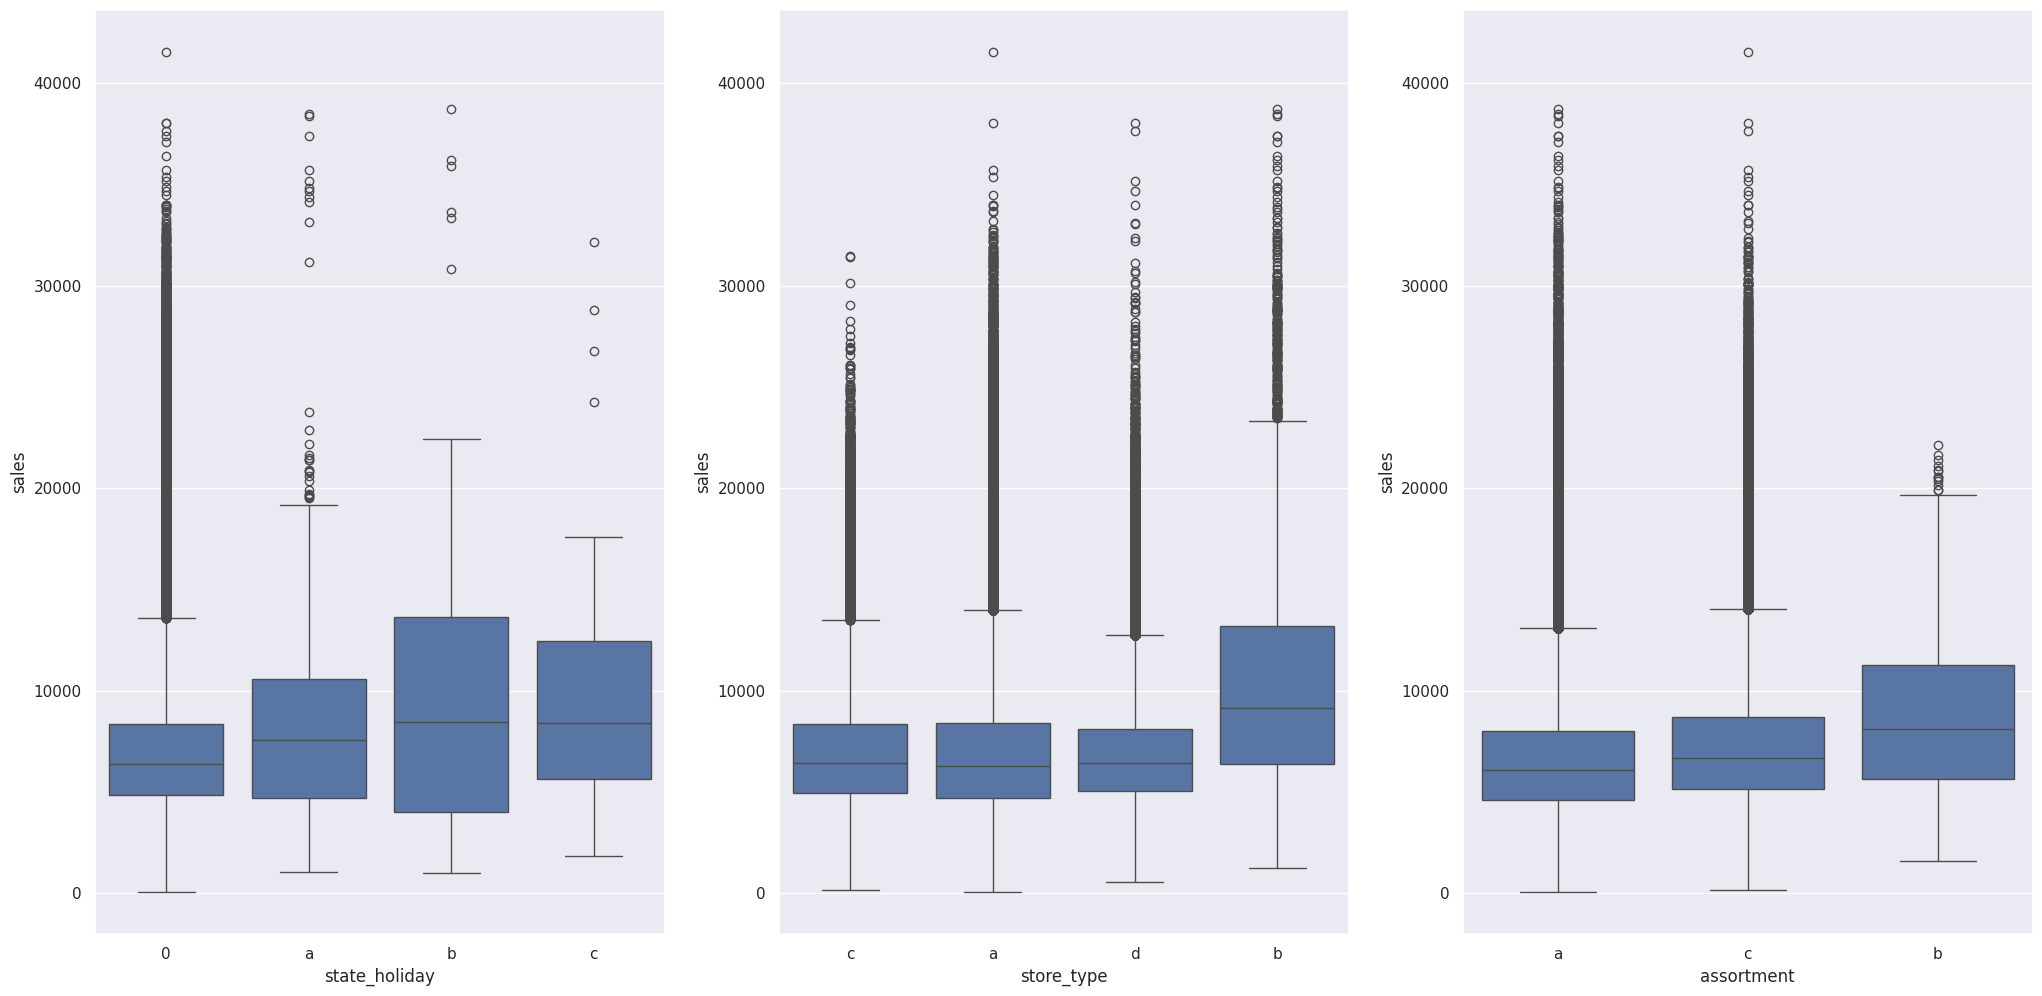

In [17]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux1)


# 2.0 FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

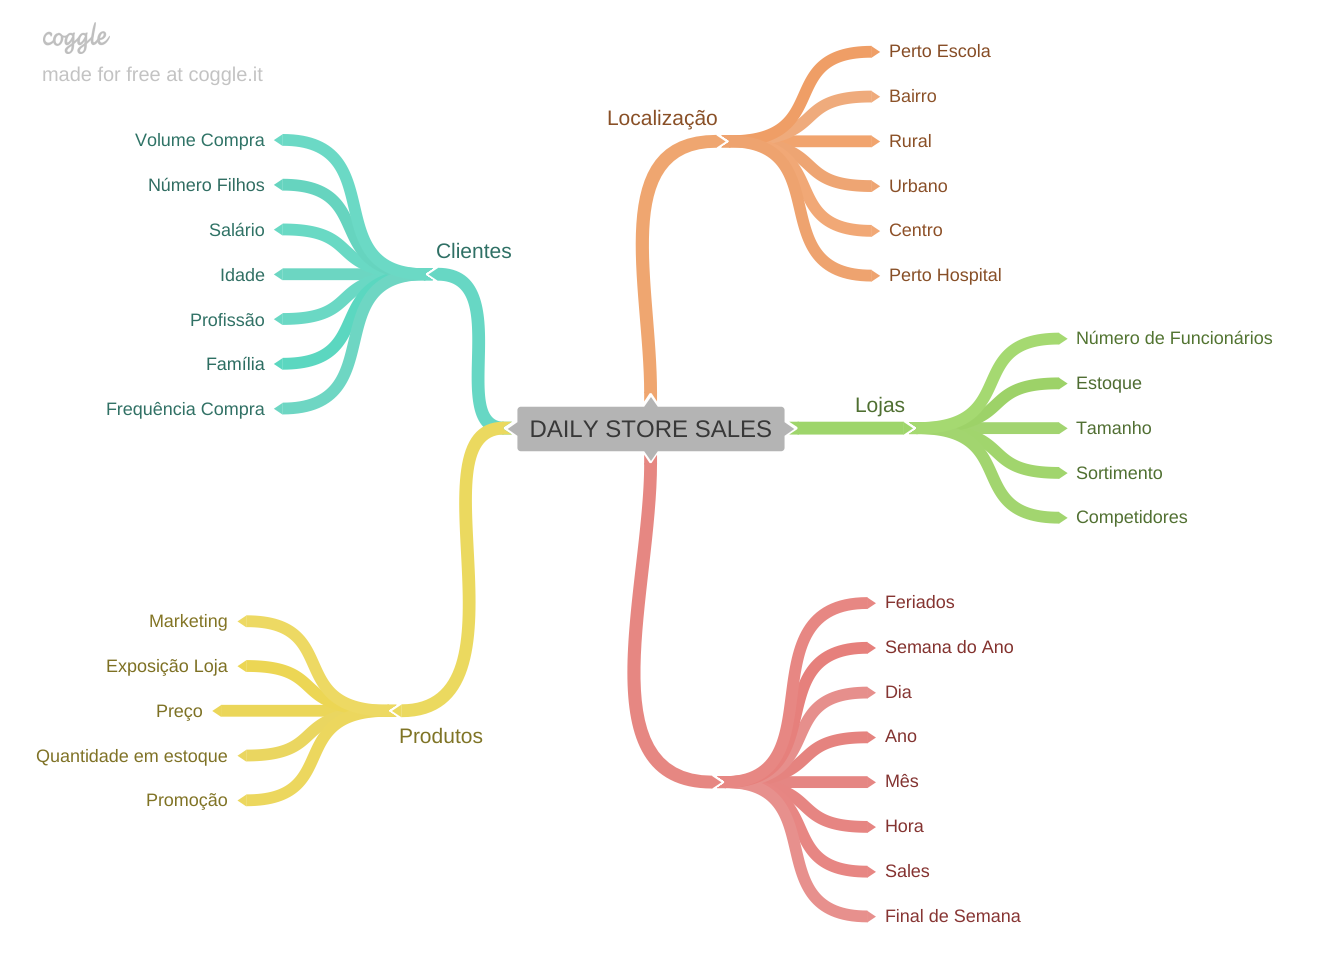

In [19]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores  por mais tempo nos produtos deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.
    
**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [24]:
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [25]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

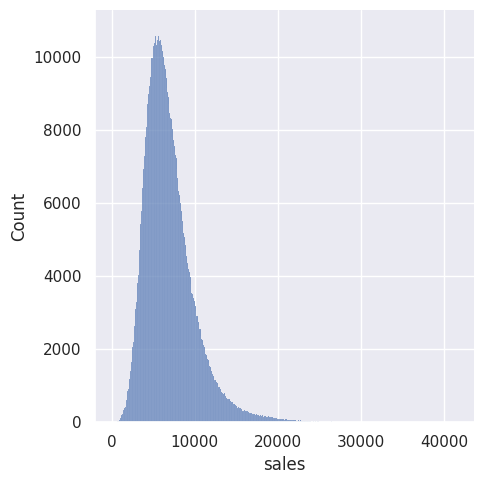

In [26]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

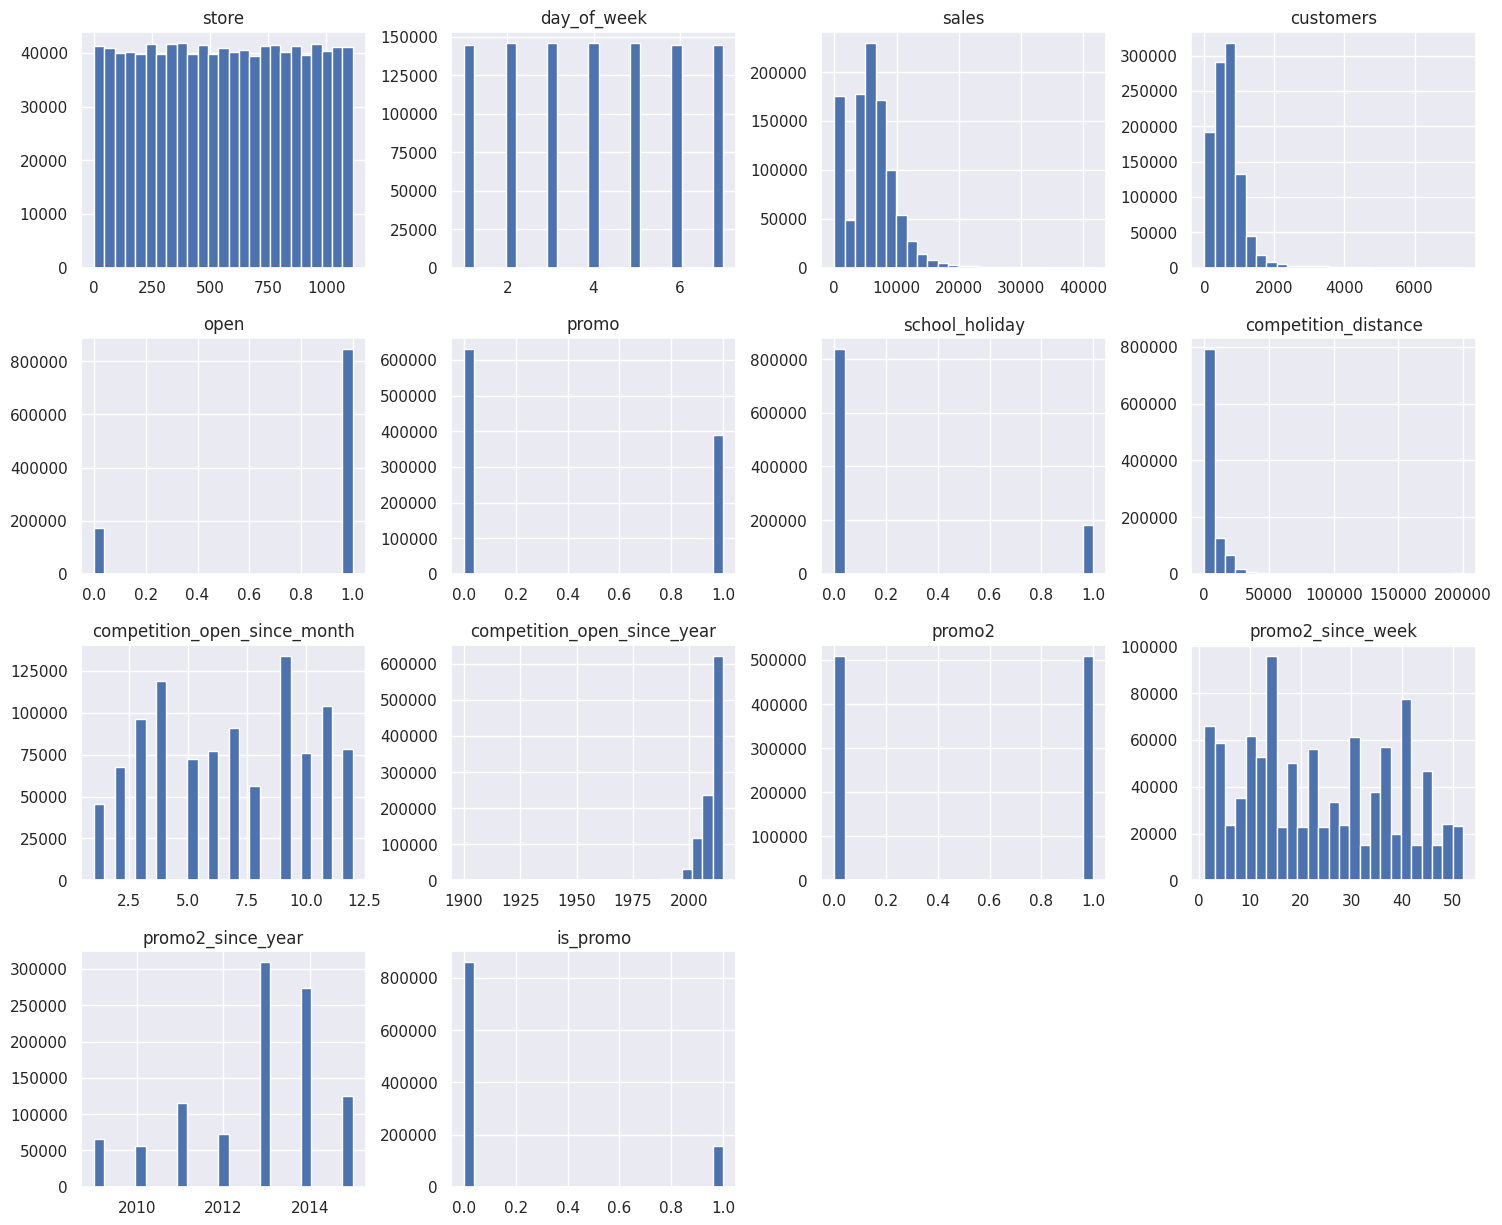

In [27]:
num_attributes.hist(bins=25, figsize=(18, 15));

### 4.1.3 Categorical Variable

<Axes: xlabel='sales', ylabel='Density'>

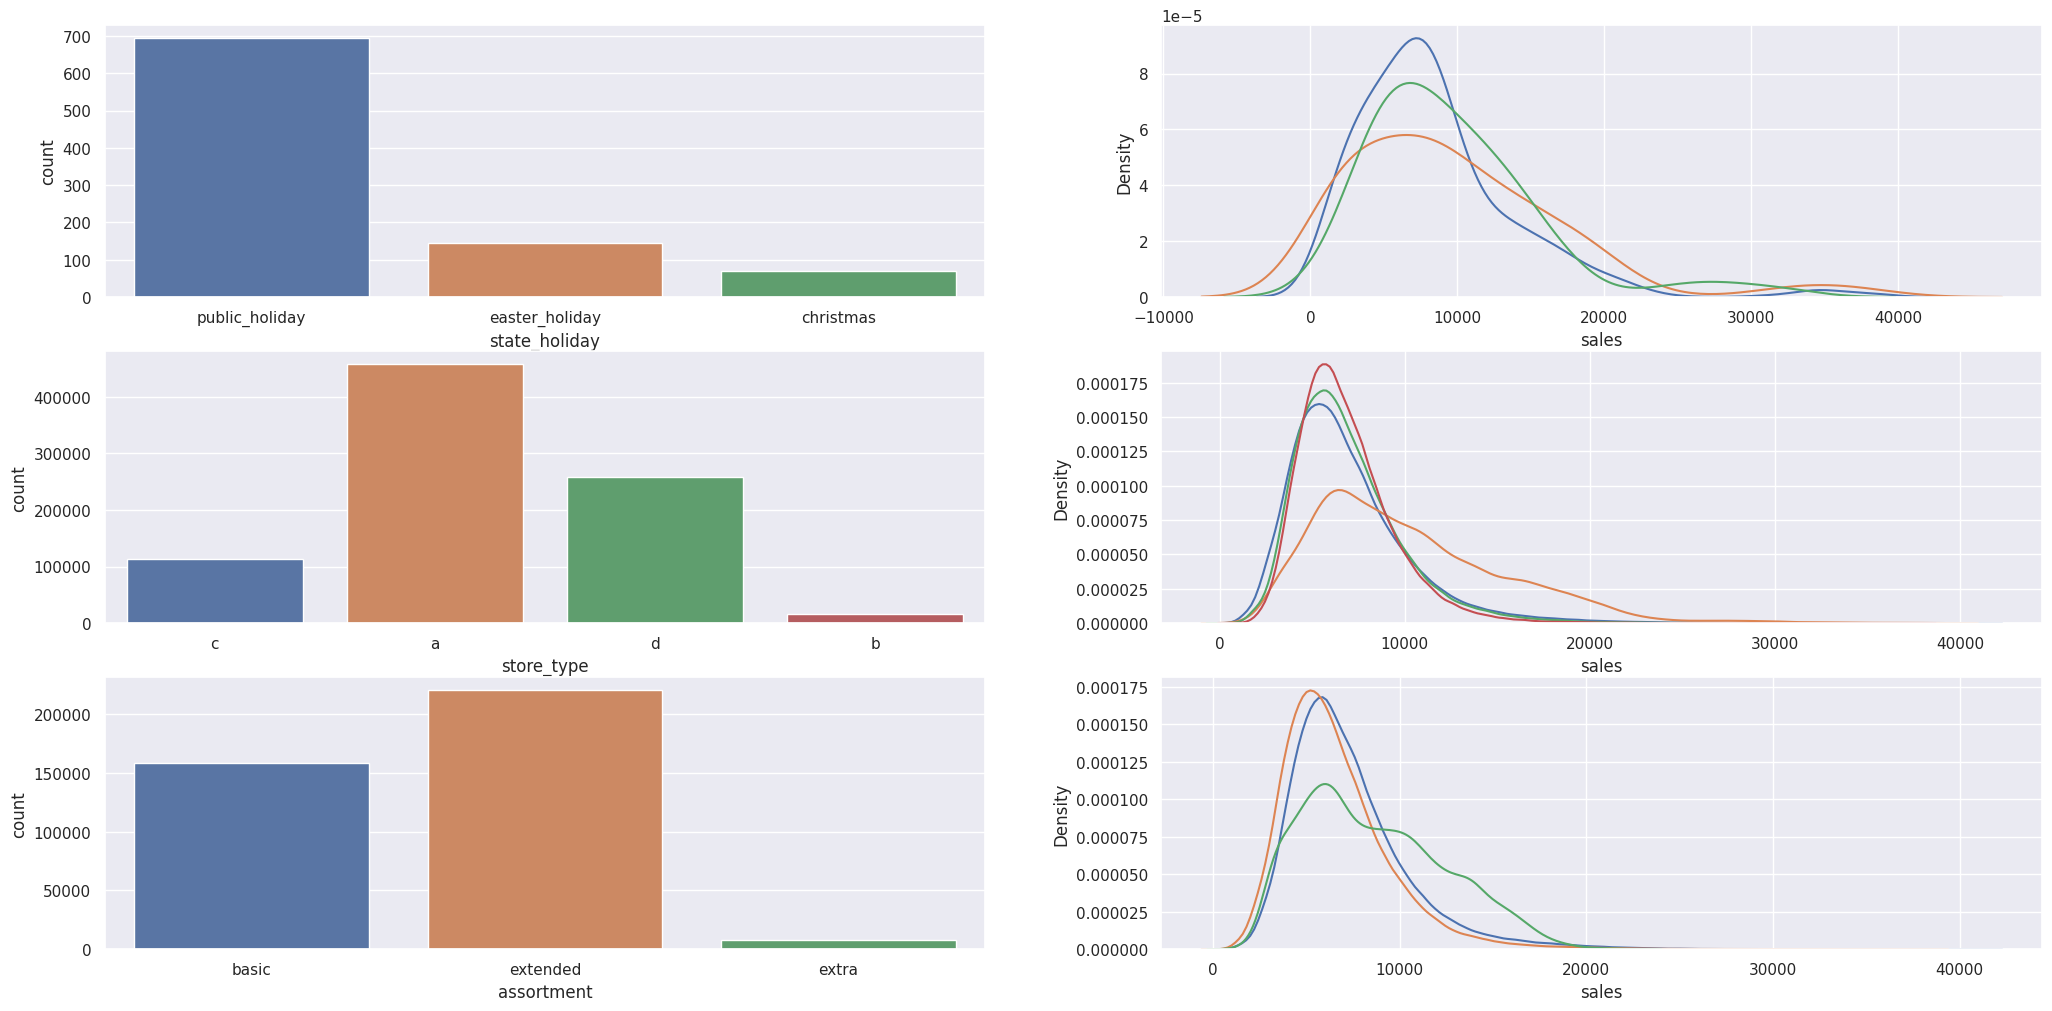

In [28]:
#plt.figure(figsize=(14, 7))

#state_holiday

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x="state_holiday",hue="state_holiday",data=a)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas')

#store_type

plt.subplot(3,2,3)
aa = df4[df4['store_type'] != 'na']
sns.countplot(x="store_type",hue="store_type",data=aa)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d')

#assortment

plt.subplot(3,2,5)
aaa = df4[df4['store_type'] != 'a']
sns.countplot(x="assortment",hue="assortment",data=aaa)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended')
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra')

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

<Axes: xlabel='year_week'>

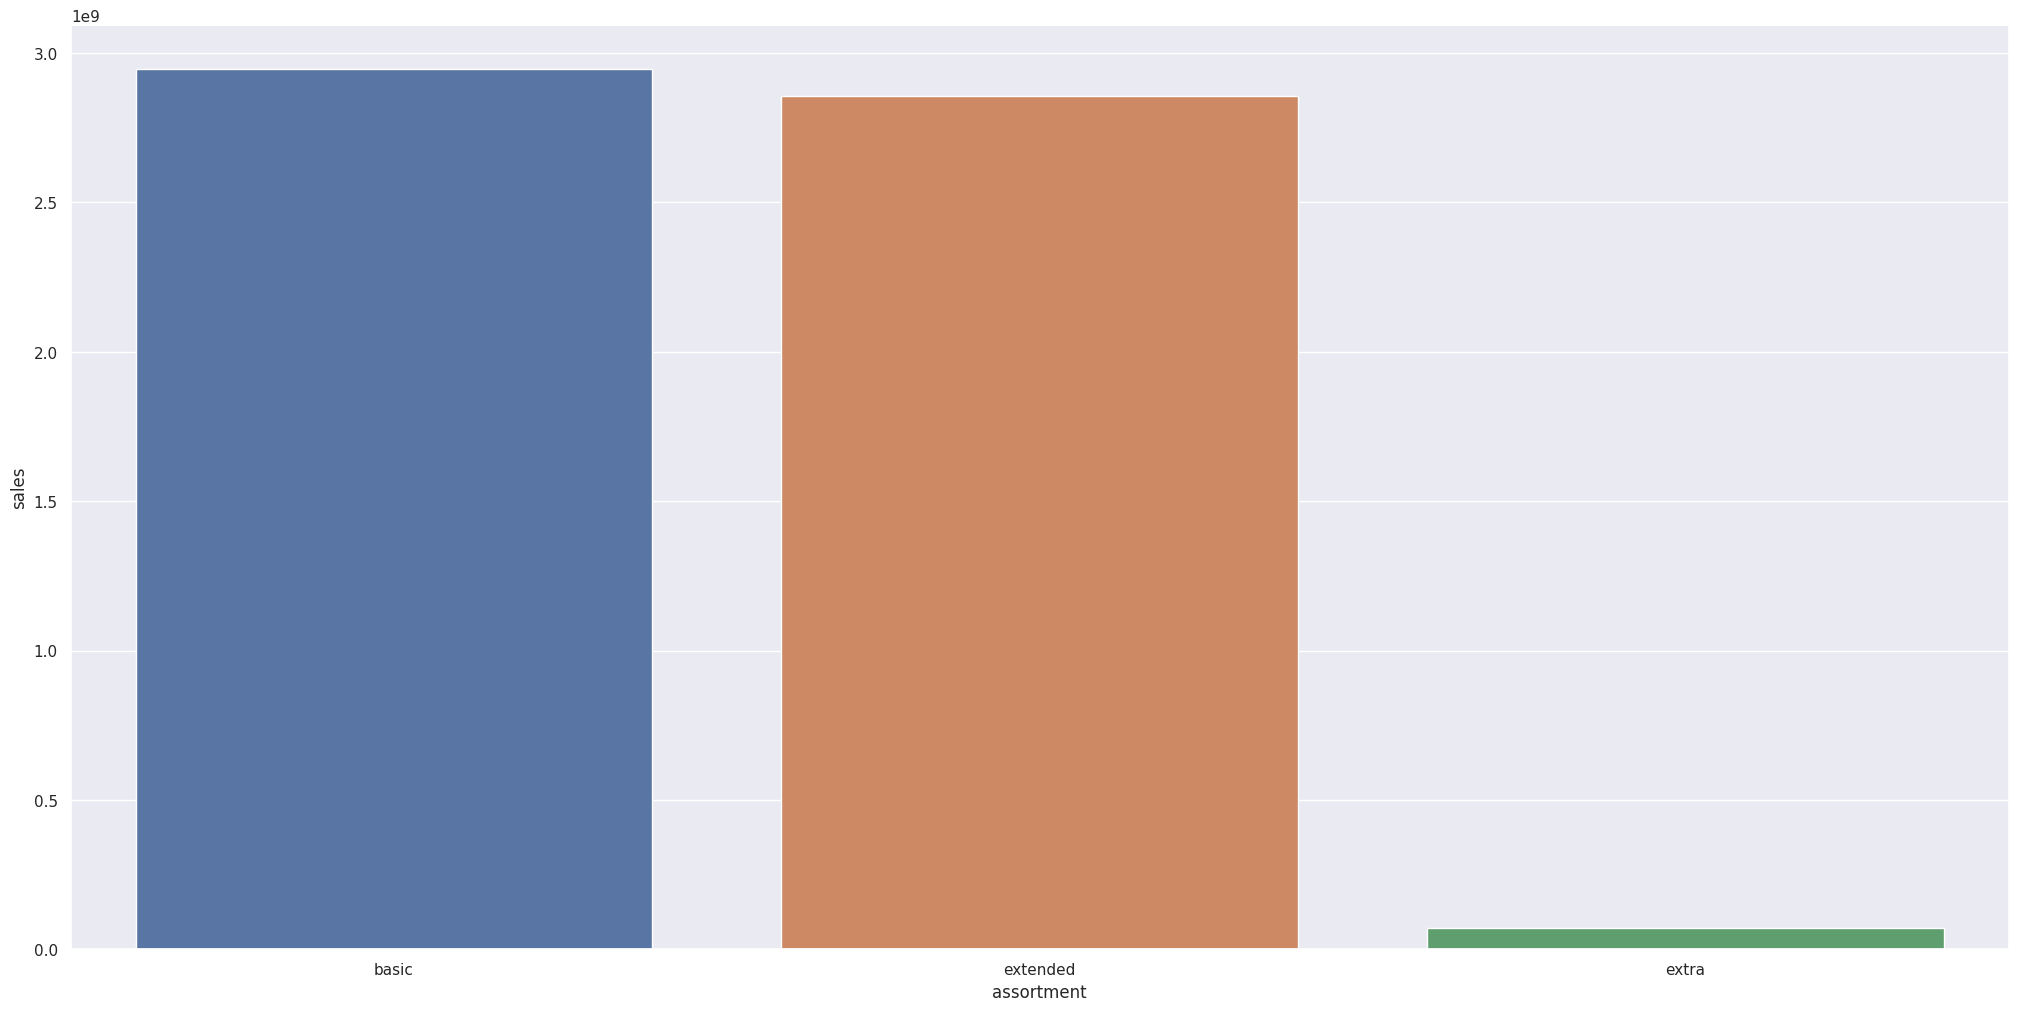

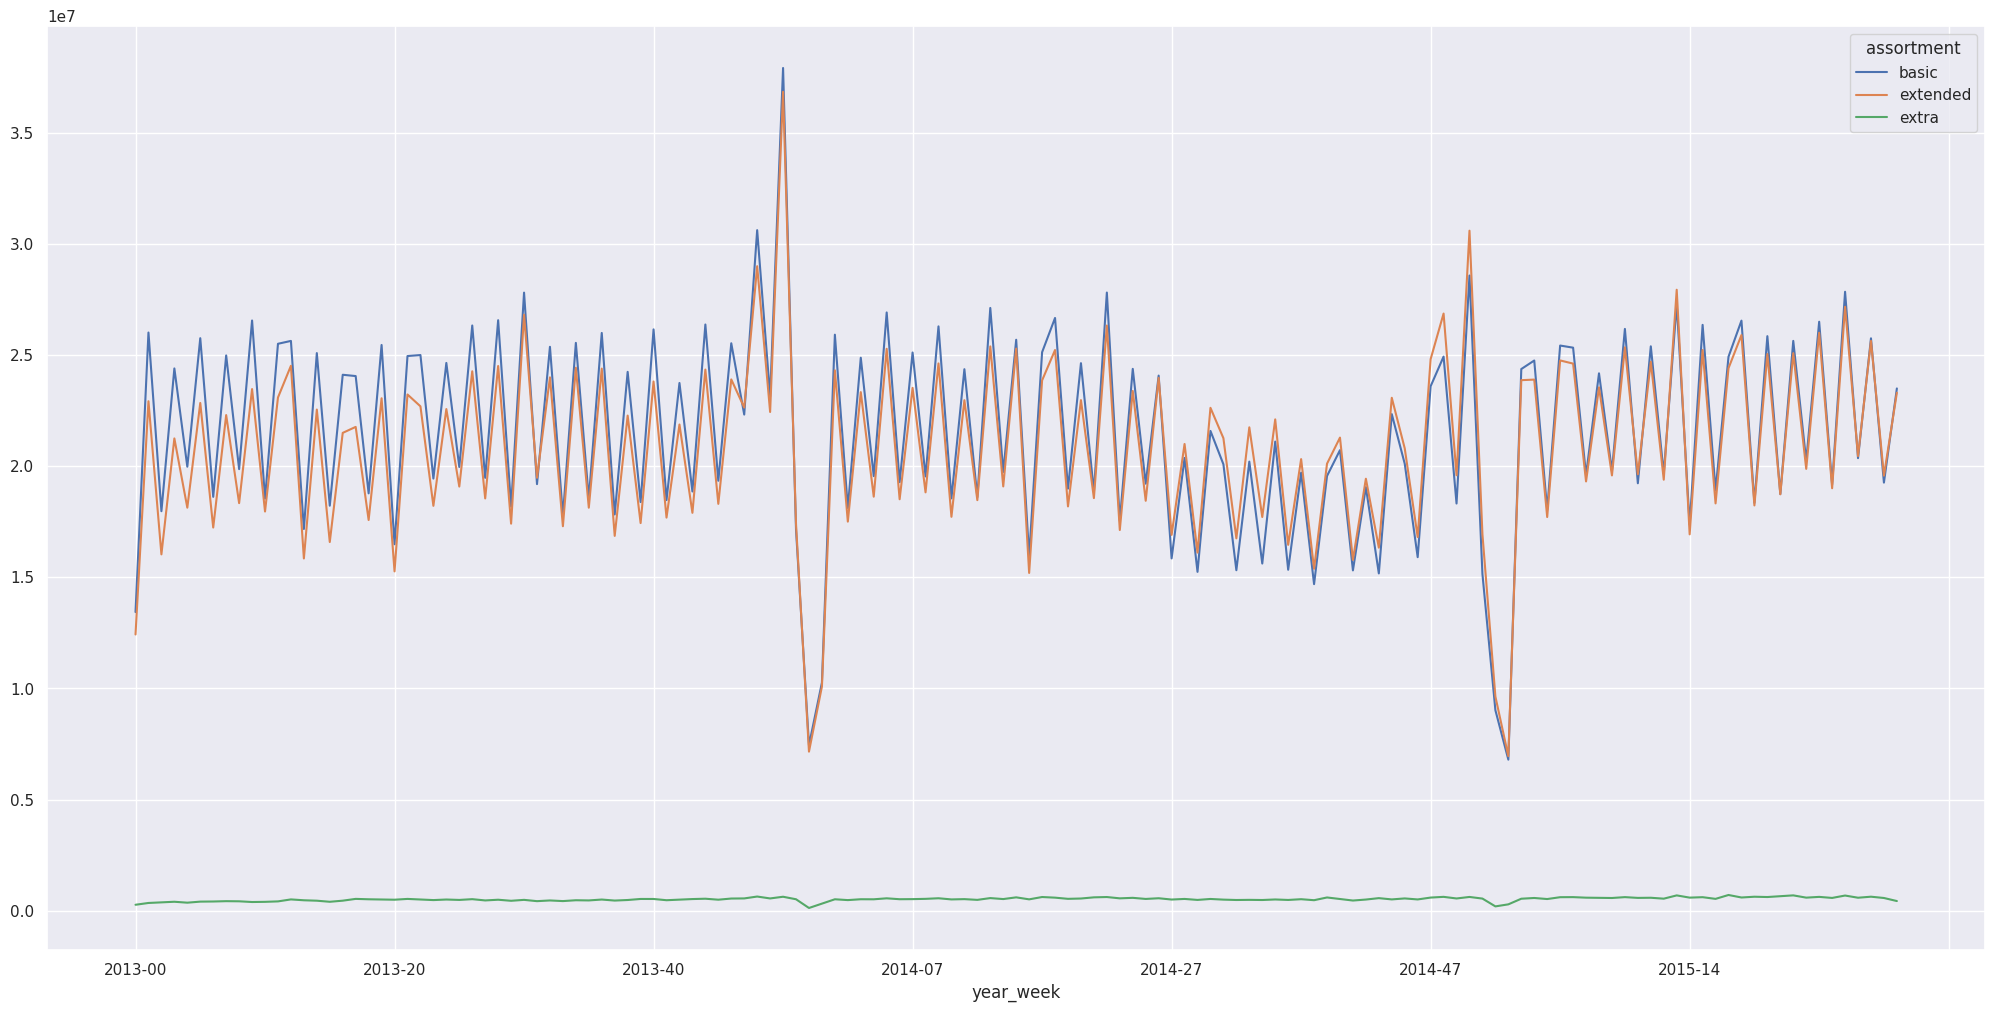

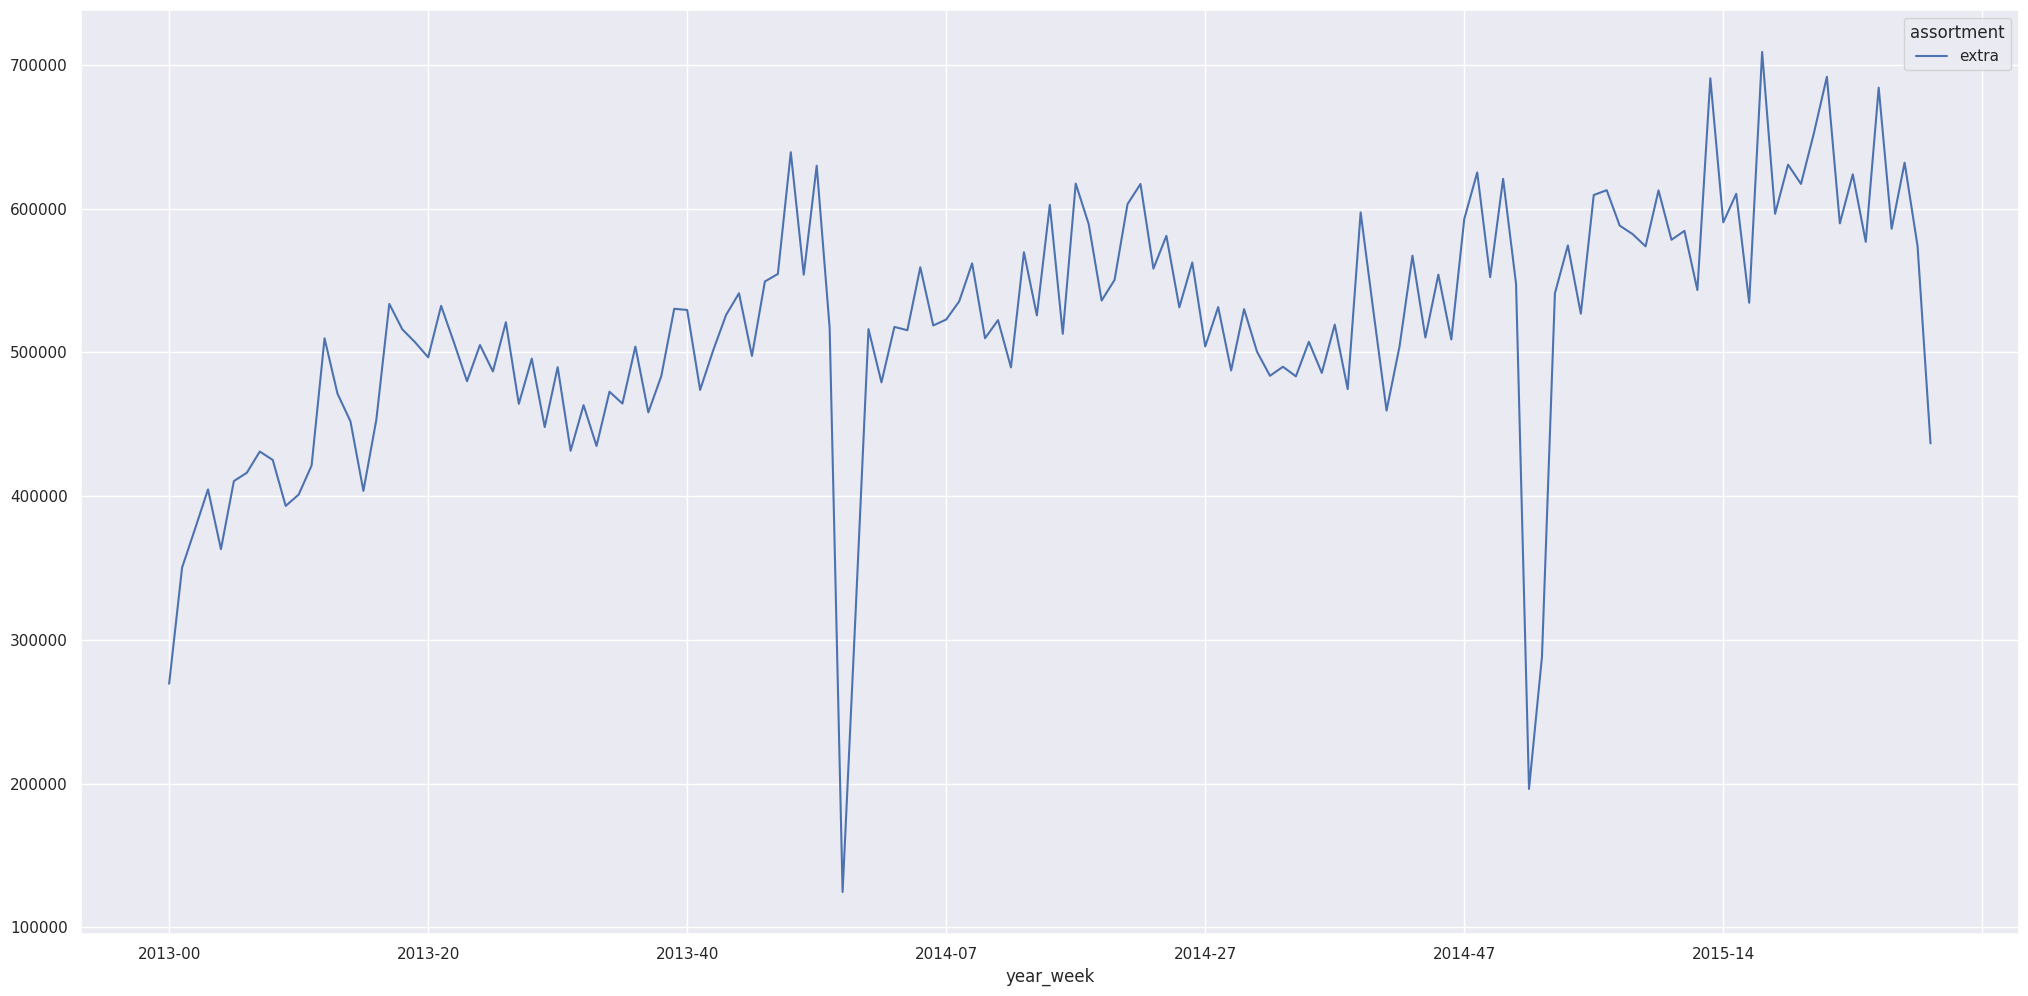

In [29]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',hue='assortment', data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index="year_week",columns="assortment",values="sales").plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index="year_week",columns="assortment",values="sales").plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

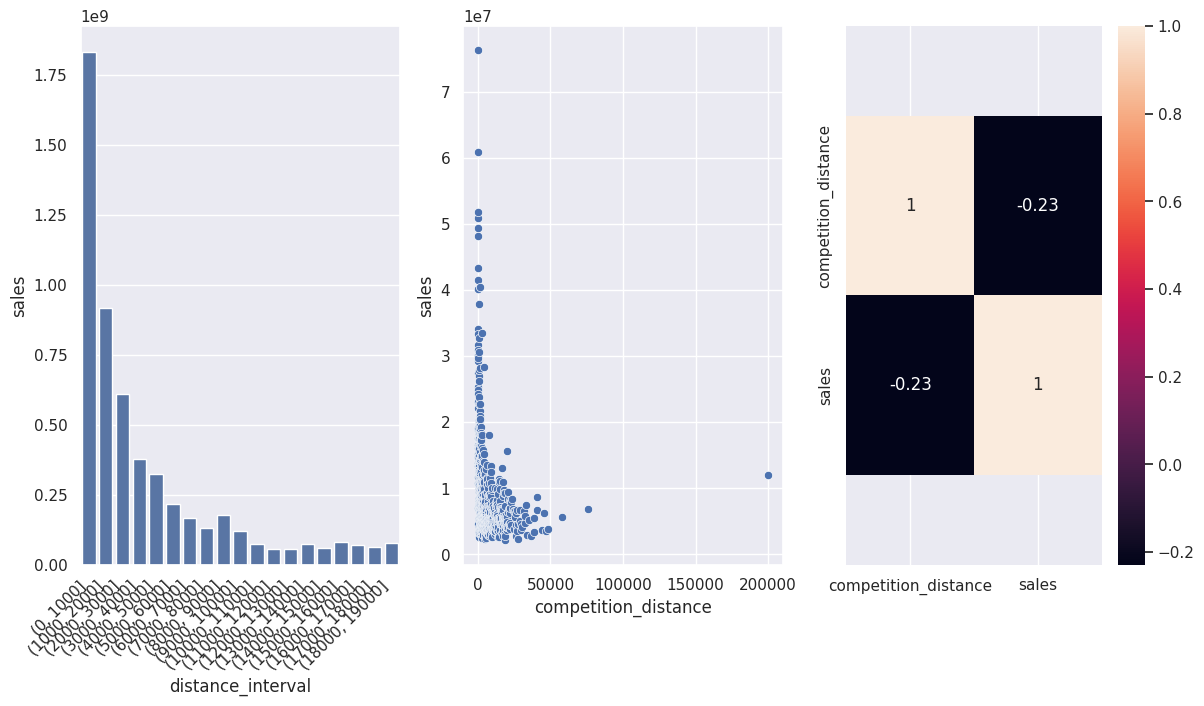

In [30]:
plt.figure(figsize=(14, 7))

bins = np.arange(0, 20000 , 1000)

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
aux1['distance_interval'] = pd.cut(aux1['competition_distance'], bins)

aux2 = aux1.groupby('distance_interval', observed=True)['sales'].sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='distance_interval', y='sales', data=aux2)
plt.xticks(rotation=45, ha='right');

plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,3)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
x = sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### H3. Lojas com competidores a mais tempo deveriam vender mais.

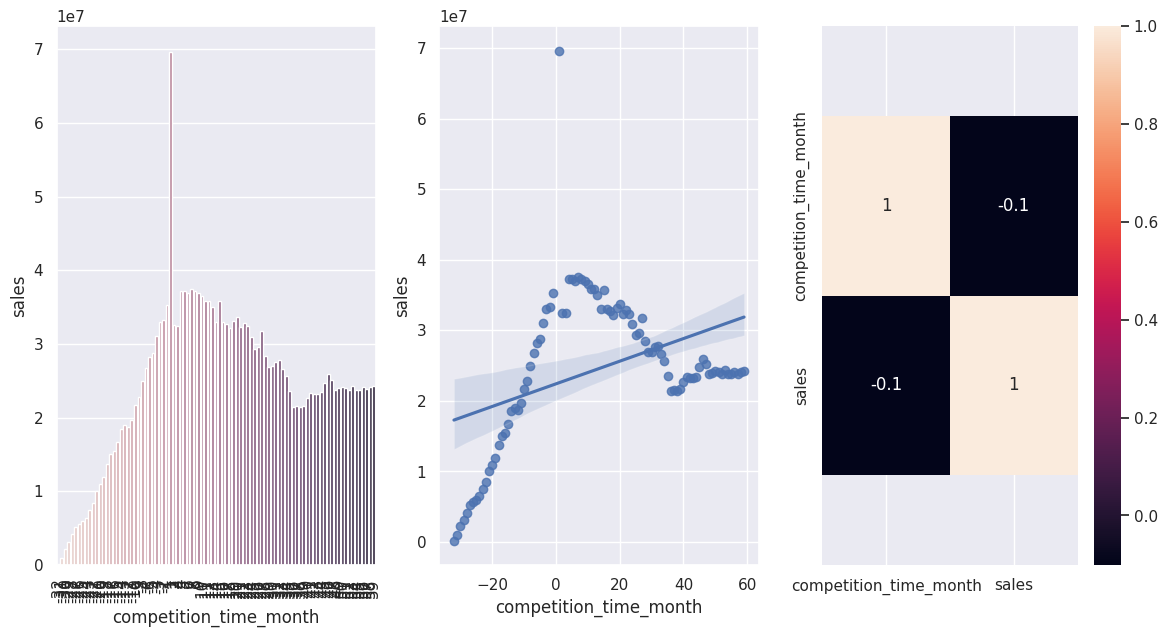

In [31]:
plt.figure(figsize=(14, 7))

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month',y='sales',hue='competition_time_month',data=aux2, legend=False)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

### H5. Lojas com mais dias de promoção deveriam vender mais

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

### H7. Lojas abertas durante feriado de Natal deveriam vender mais.

### H8. Lojas deveriam vender mais ao longo dos anos.

### H9. Lojas deveriam vender mais no segundo semestre do ano.

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

### H11. Lojas deveriam vender menos aos finais de semana.

### H12. Lojas deveriam vender menos durante os feriados escolares.

### 4.2.1 Resumo das Hipóteses

In [32]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

## 4.3.1 Numerical Attributes

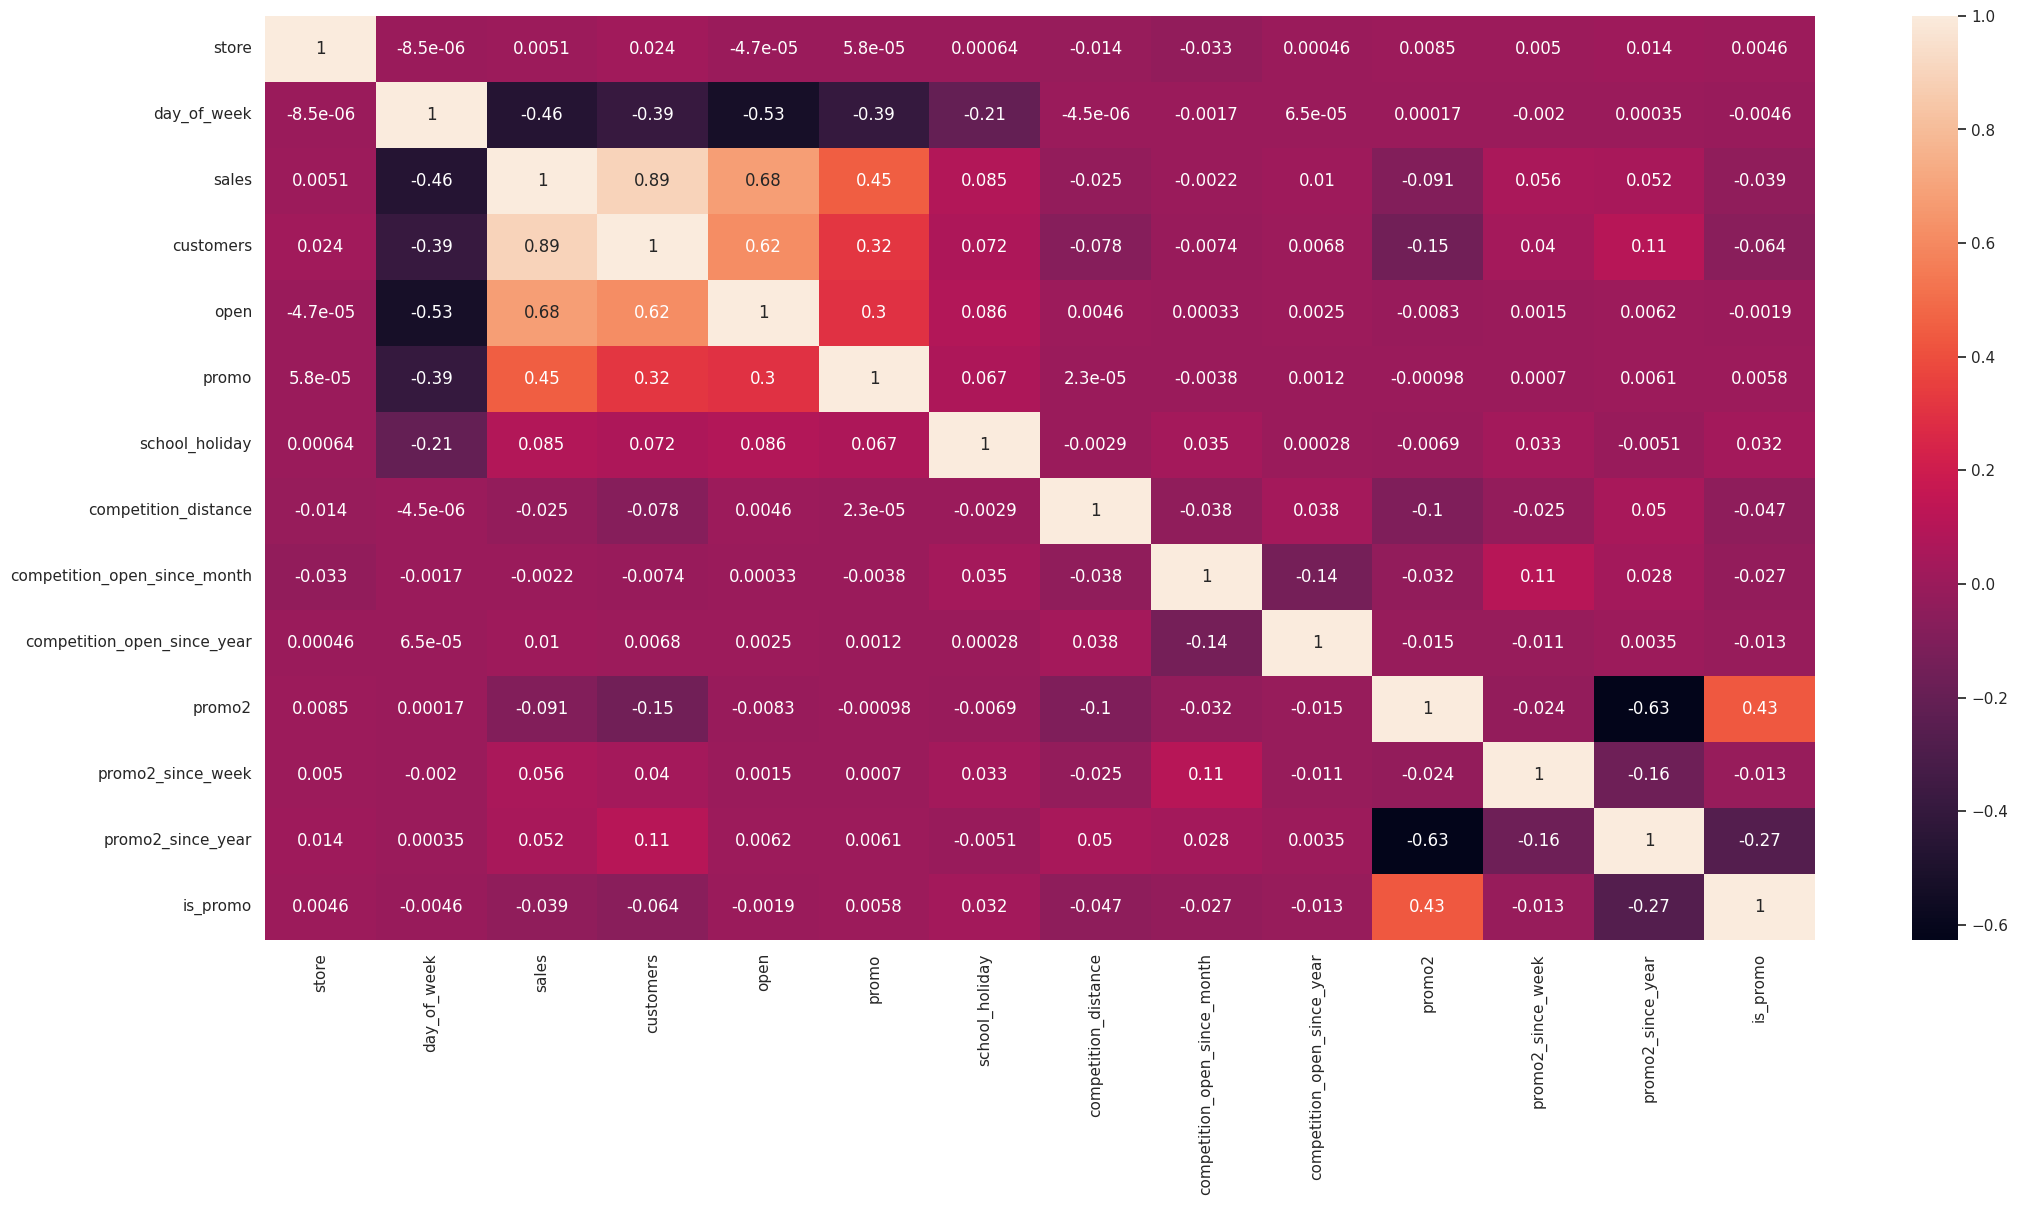

In [33]:
#plt.figure(figsize=(18, 10))
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True);

## 4.3.2 Categorical Attributes

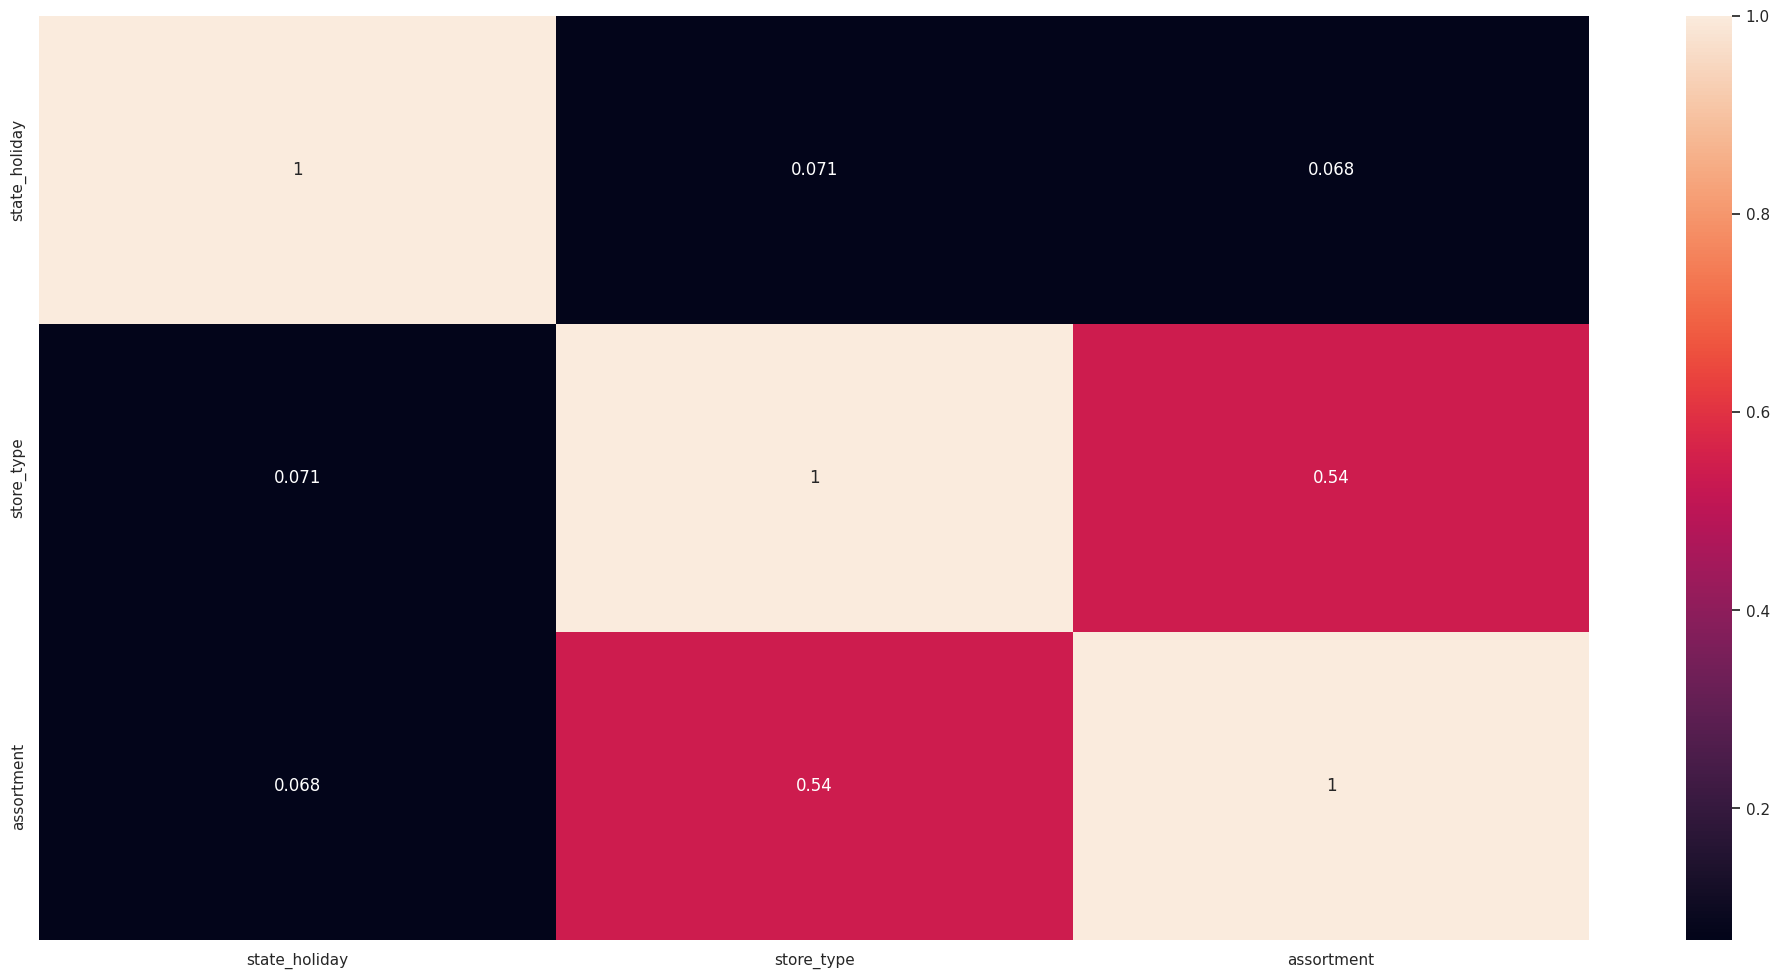

In [34]:
a = df4.select_dtypes(include='object')

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 5.0 DATA PREPARATION

In [35]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

<Axes: ylabel='year'>

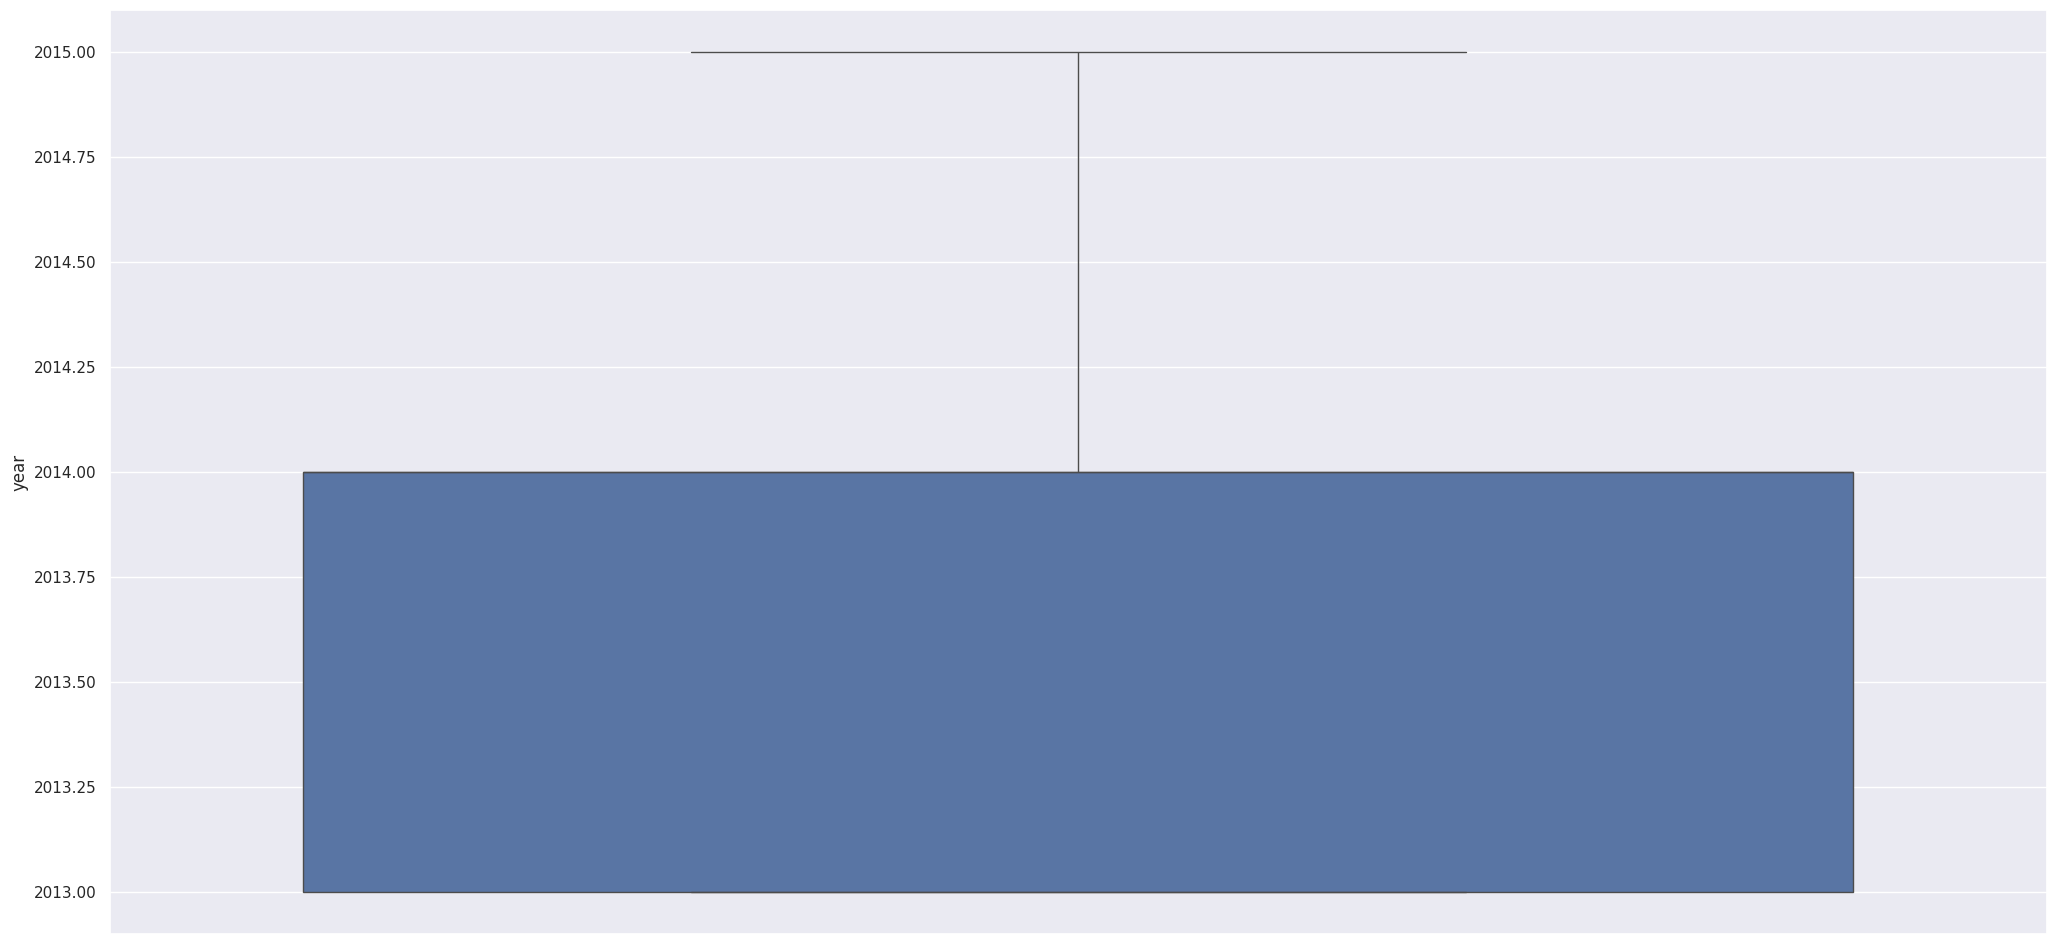

In [48]:
a = df5.select_dtypes(include=['int64','float64'])
sns.boxplot(df5['year'])

In [49]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

/tmp/ipykernel_30261/2509101140.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

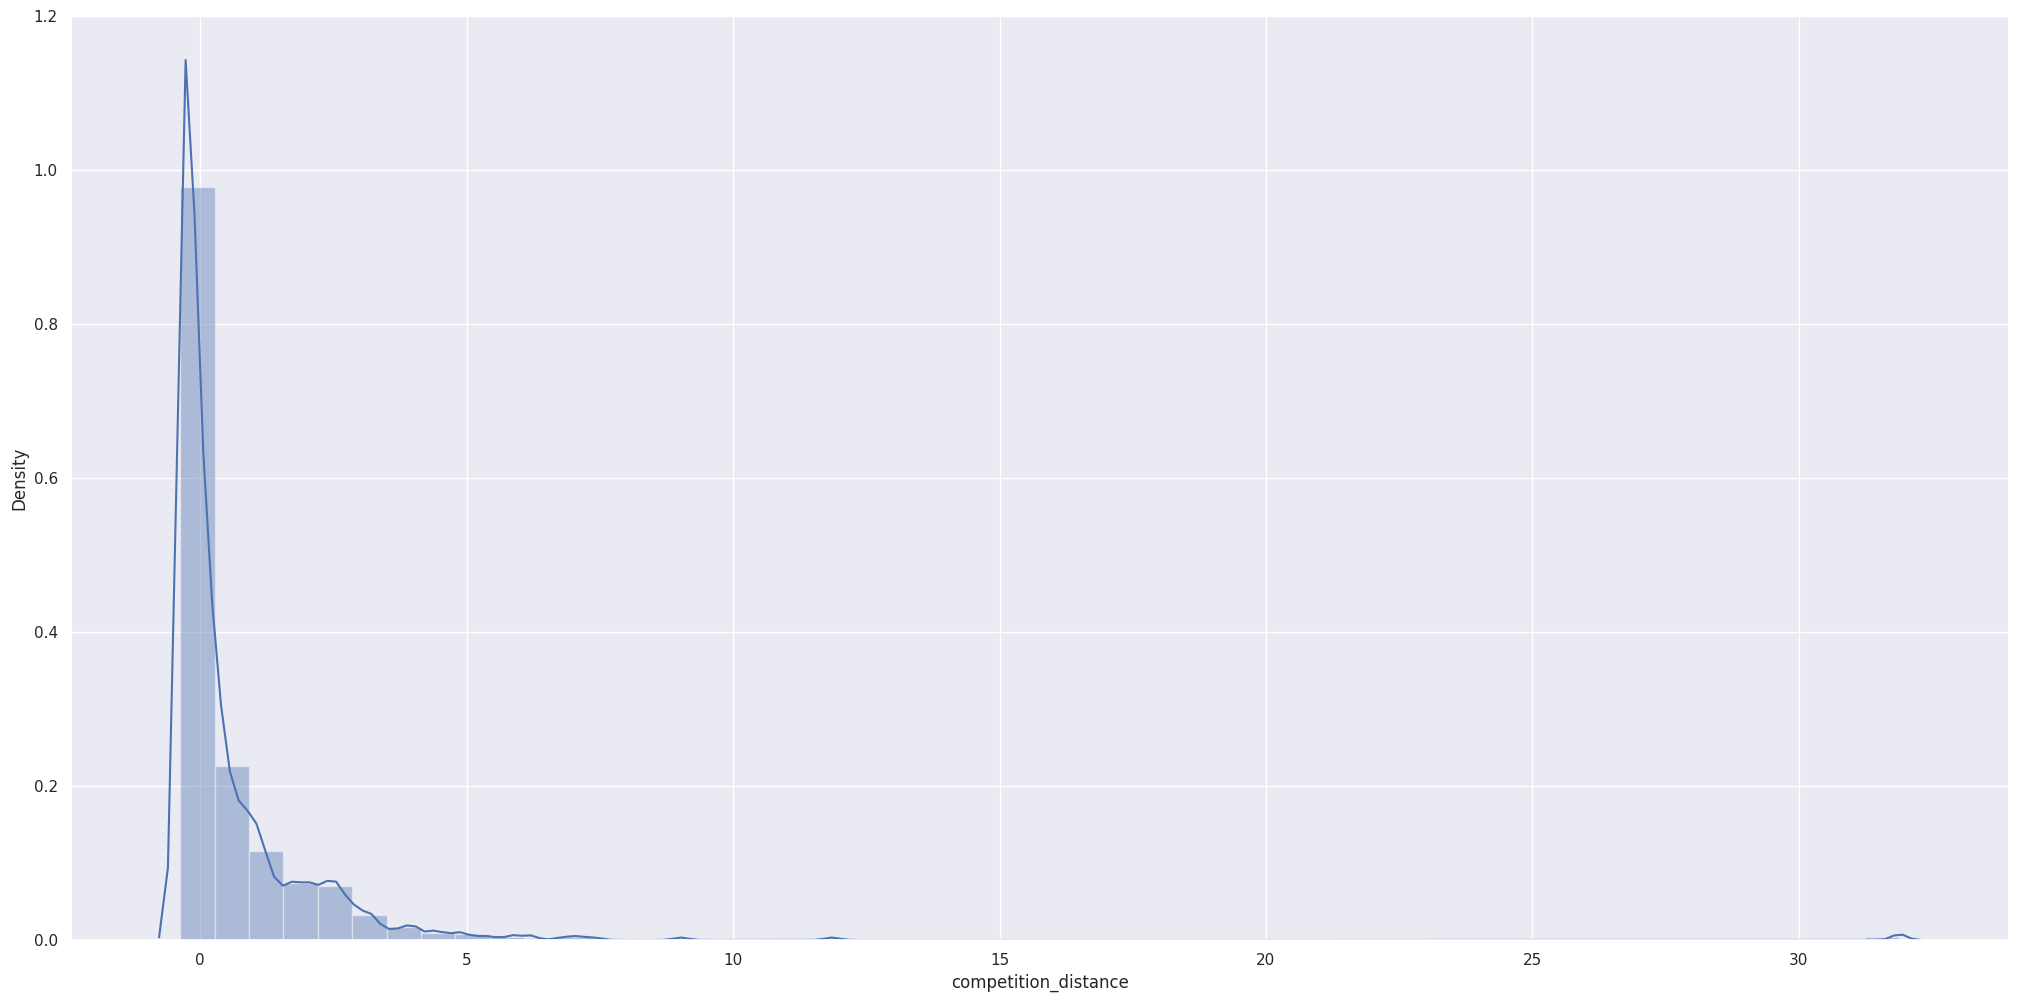

In [52]:
sns.distplot(df5['competition_distance'])

## 5.3 Transformação

In [ ]:
#month
#day
#week of year
#day of week